In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements_table = Base.classes.measurement
stations_table = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
final_date = '0000-00-00'

for row in session.query(measurements_table):
    if (final_date < row.date):
        final_date = row.date

final_date = dt.datetime.strptime(final_date, '%Y-%m-%d')
final_date = final_date.replace(year=final_date.year - 1)

print(f"First Allowed Date: {final_date.strftime('%m/%d/%Y')}")

# Perform a query to retrieve the data and precipitation scores
data = session.query(
    measurements_table.date,
    measurements_table.prcp
).filter(measurements_table.date >= final_date.strftime('%Y-%m-%d'))

# Save the query results as a Pandas DataFrame and set the index to the date column
Precip = pd.DataFrame(data, columns=['Date', 'Precipitation']).dropna()
Precip.set_index('Date', inplace=True)

# # Sort the dataframe by date
Precip = Precip.sort_index()

# Last prints to confirm data works as intended
print(f"Total valid precipitation points found: {Precip.count().max()}")
print(f"Total distinct dates collected: {Precip.groupby('Date').count().count().min()}")
Precip.head(10)

First Allowed Date: 08/23/2016
Total valid precipitation points found: 2021
Total distinct dates collected: 366


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


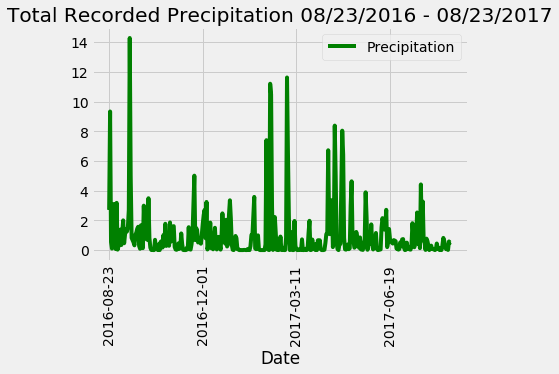

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
Precip.groupby('Date').sum().plot(
    title = f"Total Recorded Precipitation {final_date.strftime('%m/%d/%Y')} - {final_date.replace(year=final_date.year + 1).strftime('%m/%d/%Y')}",
    color='green',
    rot=90
)
plt.show()

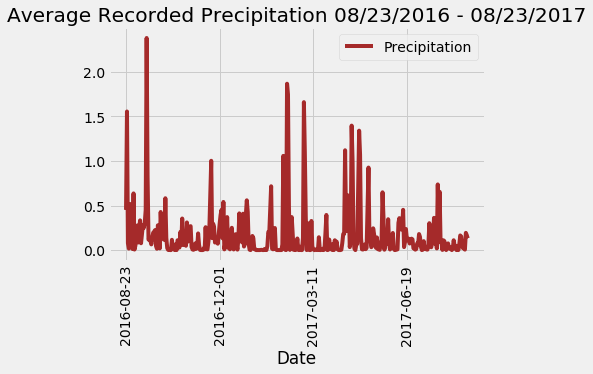

In [12]:
Precip.groupby('Date').mean().plot(
    title = f"Average Recorded Precipitation {final_date.strftime('%m/%d/%Y')} - {final_date.replace(year=final_date.year + 1).strftime('%m/%d/%Y')}",
    color='brown',
    rot=90
)
plt.show()

##### Disclaimer: It's not clear if this is data is best represented by the average precipitation recorded or the total precipitation recorded on each day; so I plotted both.  I also grouped the data based on the station the data was taken from.

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(f"Summary stats based on data as individual points:\n{Precip['Precipitation'].describe()}\n")
print(f"Summary stats based on average for each date data was taken from:\n{Precip.groupby('Date').mean()['Precipitation'].describe()}\n")
print(f"Summary stats based on total precipitation per date:\n{Precip.groupby('Date').sum()['Precipitation'].describe()}")

Summary stats based on data as individual points:
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

Summary stats based on average for each date data was taken from:
count    366.000000
mean       0.170757
std        0.295683
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: Precipitation, dtype: float64

Summary stats based on total precipitation per date:
count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: Precipitation, dtype: float64


In [14]:
# Design a query to show how many stations are available in this dataset?
stations_avail = session.query(stations_table.station)

print(f"There are {stations_avail.count()} stations shared between the two tables.")

There are 9 stations shared between the two tables.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(
    measurements_table.station,
    func.count()
).group_by(
    measurements_table.station
).order_by(
    -func.count()
).all()

for row in active_stations:
    print(f"Station {row[0]} has {row[1]} recorded events")

Station USC00519281 has 2772 recorded events
Station USC00519397 has 2724 recorded events
Station USC00513117 has 2709 recorded events
Station USC00519523 has 2669 recorded events
Station USC00516128 has 2612 recorded events
Station USC00514830 has 2202 recorded events
Station USC00511918 has 1979 recorded events
Station USC00517948 has 1372 recorded events
Station USC00518838 has 511 recorded events


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_id = active_stations[0][0]

temp_min = session.query(
    func.min(measurements_table.tobs)
).filter(measurements_table.station == highest_id).all()

temp_max = session.query(
    func.max(measurements_table.tobs)
).filter(measurements_table.station == highest_id).all()

temp_avg = session.query(
    func.avg(measurements_table.tobs)
).filter(measurements_table.station == highest_id).all()

print(f"For station {highest_id}:\n-the highest temp is {temp_max[0][0]}F;\n-the lowest temp is {temp_min[0][0]}F; and\n-the average temp is {temp_avg[0][0]}F.")

For station USC00519281:
-the highest temp is 85.0F;
-the lowest temp is 54.0F; and
-the average temp is 71.66378066378067F.


First Allowed Date: 08/18/2016


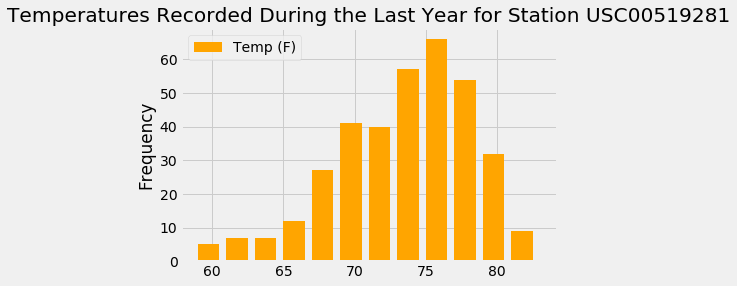

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Gotta recalculate the starting date for the last 12 months of this particular station's data collection
final_date = '0000-00-00'

for row in session.query(measurements_table).filter(measurements_table.station == highest_id):
    if (final_date < row.date):
        final_date = row.date

final_date = dt.datetime.strptime(final_date, '%Y-%m-%d')
final_date = final_date.replace(year=final_date.year - 1)

print(f"First Allowed Date: {final_date.strftime('%m/%d/%Y')}")

# Now we can get the data and plot the histogram
temp_obs = session.query(measurements_table.date, measurements_table.tobs).\
filter(measurements_table.date >= final_date.strftime('%Y-%m-%d')).\
filter(measurements_table.station == highest_id).\
group_by(measurements_table.date).all()

Temp_Obs = pd.DataFrame(temp_obs, columns=['date', 'Temp (F)'])
Temp_Obs.plot.hist(
    title=f"Temperatures Recorded During the Last Year for Station {highest_id}",
    color='orange',
    width=1.5,
    bins=12
)
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements_table.tobs), func.avg(measurements_table.tobs), func.max(measurements_table.tobs)).\
        filter(measurements_table.date >= start_date).filter(measurements_table.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]
print(f"min temp: {tmin}\navg temp: {tavg}\nmax temp: {tmax}")

min temp: 61.0
avg temp: 69.75510204081633
max temp: 75.0


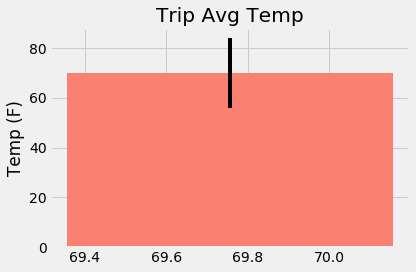

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_bar = plt.bar(
    tavg,
    height=tavg,
    color='salmon',
    yerr=tmax - tmin
)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_sum = session.query(measurements_table.station, measurements_table.tobs).\
filter(measurements_table.date >= '2011-03-05').\
filter(measurements_table.date <= '2012-02-28').\
group_by(measurements_table.station).order_by(-measurements_table.tobs).all()

print("Total Rainfal Between 2011-03-05 and 2012-02-28 per Station")
for tup in rain_sum:
    print(f"{tup[0]}: {tup[1]}")

Total Rainfal Between 2011-03-05 and 2012-02-28 per Station
USC00511918: 73.0
USC00517948: 72.0
USC00518838: 70.0
USC00513117: 69.0
USC00516128: 69.0
USC00519397: 69.0
USC00519523: 69.0
USC00514830: 68.0
USC00519281: 67.0


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements_table.tobs), func.avg(measurements_table.tobs), func.max(measurements_table.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements_table.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2011-03-05', '%Y-%m-%d')
end_date = dt.datetime.strptime('2012-02-28', '%Y-%m-%d')

# Use the start and end date to create a range of dates
date_range = session.query(measurements_table.date).\
filter(measurements_table.date >= start_date.strftime('%Y-%m-%d')).\
filter(measurements_table.date <= end_date.strftime('%Y-%m-%d')).\
group_by(measurements_table.date).all()

date_range = list(np.ravel(date_range))

# Stip off the year and save a list of %m-%d strings
query_dates = []
for i in range(0, len(date_range)):
    sub_date = dt.datetime.strptime(date_range[i], '%Y-%m-%d')
    query_dates.append(sub_date.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for date in query_dates:
    normals.append(list(np.ravel(daily_normals(date))))

print(f"Entry Count: {len(normals)}")

Entry Count: 361


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Plot_Data = pd.DataFrame(
    normals,
    columns=['Temp Min', 'Temp Avg', 'Temp Max'],
    index = pd.Index(data=date_range, name='Date')
)
Plot_Data.head()

,Temp Min,Temp Avg,Temp Max
Date,,,
2011-03-05,60.0,67.890909,76.0
2011-03-06,60.0,69.203390,76.0
2011-03-07,60.0,69.172414,78.0
2011-03-08,59.0,68.724138,78.0
2011-03-09,57.0,68.561404,75.0


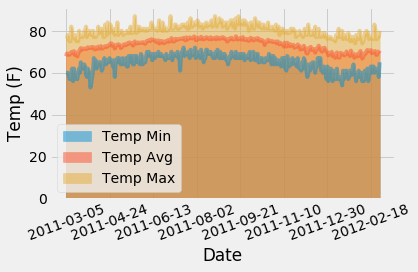

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
Plot_Data.plot.area(stacked=False, rot=20)
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.show()